In [4]:
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy
# import scipy.sparse as sparse
import urllib.request
import pybedtools
from pybedtools import BedTool
import warnings
# from sklearn.neighbors import NearestNeighbors
import statsmodels as sm
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.proportion import proportions_ztest
from numba import jit
import numba
import pickle

sys.path.append('/home/camiel/chromograph/')
# from chromograph.plotting.UMI_plot import UMI_plot
import chromograph
from chromograph.peak_calling.utils import *

import cytograph as cg

from umap import UMAP
import sklearn.metrics
from scipy.spatial import distance
import community
import networkx as nx
from scipy import sparse
from typing import *

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [7]:
## Connect to file

# f = '/data/proj/scATAC/chromograph/build_20191205/Midbrain.loom'
f = '/data/proj/scATAC/chromograph/build_20191206/Cerebellum.loom'
ref = '/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/'
ds = loompy.connect(f, mode='r')
print(ds.shape)
blayer = str(int(ds.attrs['bin_size']/1000)) + 'kb_bins'
print(sum(ds.ca['passed_filters']>100000))
print(sum(ds.ca['passed_filters']<5000))
print(sum(ds.ca['passed_filters']<10000))
print('min' + min(ds.ca['passed_filters']))

ds.close()

(617643, 17811)
366
442
3341


TypeError: can only concatenate str (not "numpy.int64") to str

(0, 6.5)

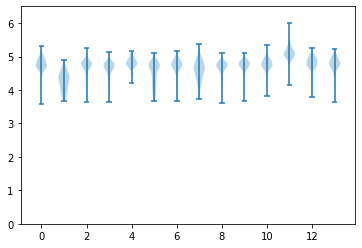

In [84]:
pos = np.unique(ds.ca['Clusters'])
data = [np.log10(ds.ca['passed_filters'][ds.ca['Clusters'] == x]) for x in pos]

plt.violinplot(data, pos)
plt.ylim((0,6.5))

In [25]:
## Aggregrate bins
Clus = np.unique(ds.ca['Clusters'])
Csum = []

for x in Clus:
    logging.info(f"Computing sum cluster {x}")
    cells = ds.ca['Clusters'] == x
    Csum.append(np.sum(ds[blayer][:,cells], axis=1))

16:25:05 INFO     Computing sum cluster 0


KeyboardInterrupt: 

In [14]:
# from statsmodels.stats.proportion import proportions_ztest

# Zarr = []
# Parr = []

# for clus in Clus:
#     zscore = []
#     pval = []

# #     fac = np.mean(ds.ca['NBins'][ds.ca['Clusters'] == clus]) / np.mean(ds.ca['NBins'][ds.ca['Clusters'] == clus])

# #     n1 = sum(ds.ca['Clusters'] == clus) / fac
#     n1 = sum(ds.ca['Clusters'] == clus)
#     n2 = ds.shape[1] - n1

#     for x in range(ds.shape[0]):
#         ## Get success rates
#         s1 = Csum[clus][x]
#         s2 = ds.ra['NCells'][x] - s1

#         if np.logical_or(s1, s2):
#             ## Get zscore and p-value
#             z,p = proportions_ztest([s1, s2], [n1, n2], alternative='larger')
#             zscore.append(z)
#             pval.append(p)
#         else:
#             zscore.append(0)
#             pval.append(1)
    
#     (_, q, _, _) = multipletests(pval, 0.1, method="fdr_bh")
#     Zarr.append(zscore)
#     Parr.append(q)
#     logging.info(f"Enrichment calculated for cluster {clus}")
    
# Zarr = np.array(Zarr).T
# Parr = np.array(Parr).T

# ds.ra['Zscore'] = Zarr
# ds.ra['Pval_Zscore'] = Parr

19:38:24 INFO     Enrichment calculated for cluster 0
19:39:40 INFO     Enrichment calculated for cluster 1
19:40:56 INFO     Enrichment calculated for cluster 2
19:42:12 INFO     Enrichment calculated for cluster 3
19:43:29 INFO     Enrichment calculated for cluster 4
19:44:47 INFO     Enrichment calculated for cluster 5
19:46:05 INFO     Enrichment calculated for cluster 6
19:47:22 INFO     Enrichment calculated for cluster 7
19:48:41 INFO     Enrichment calculated for cluster 8
19:49:59 INFO     Enrichment calculated for cluster 9
19:51:14 INFO     Enrichment calculated for cluster 10
19:52:30 INFO     Enrichment calculated for cluster 11
19:53:46 INFO     Enrichment calculated for cluster 12
19:55:01 INFO     Enrichment calculated for cluster 13
19:56:15 INFO     Enrichment calculated for cluster 14


In [27]:
sigBins = []

quant = 100 / ds.shape[0]
for clus in Clus:
    lim = min(np.quantile(ds.ra['Pval_Zscore'][:,clus], quant), 0.05)
    print(lim)
    x = ds.ra['Pval_Zscore'][:,clus] < lim
    sigBins.append(x)
sigBins = np.array(sigBins).T

5.268623923236927e-197
0.05
9.26115310385626e-187
4.3143576987406085e-152
1.876742838571278e-40
3.522711752656576e-131
5.6114503605988974e-68
1.1307162496137614e-104
3.416488005475137e-96
5.359199228837734e-75
1.439601585604243e-132
1.502259684388567e-41
2.299528291844291e-83
1.3021386077273146e-137


In [52]:
from numba import njit

emb = 'UMAP'
ID = 95163
pos = ds.ca[emb]

b = ds.ra['ID'] == ID

@njit
def smooth_bins_jit(data, g) -> None:
    '''
    '''
    y = []
    for x in numba.prange(data.shape[1]):
        nn = g[:,x]>0
        nn_n = np.sum(nn)
        v = data[:,x] + np.sum(data[:,nn], axis=1) / (nn_n+1)
        y.append(v)
        
    return y

g = ds.col_graphs.KNN

# v = smooth_bins_jit(np.array(ds[blayer][b,:]), g.toarray())
# v = np.hstack(v)
# plt.hist(v)

# k = v > 0
# print(sum(k))
# v = v[k]

v = smooth_bins_jit(np.array(ds[blayer][:3,:]), g.toarray())
len(v)

9470

In [56]:
np.vstack(v)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

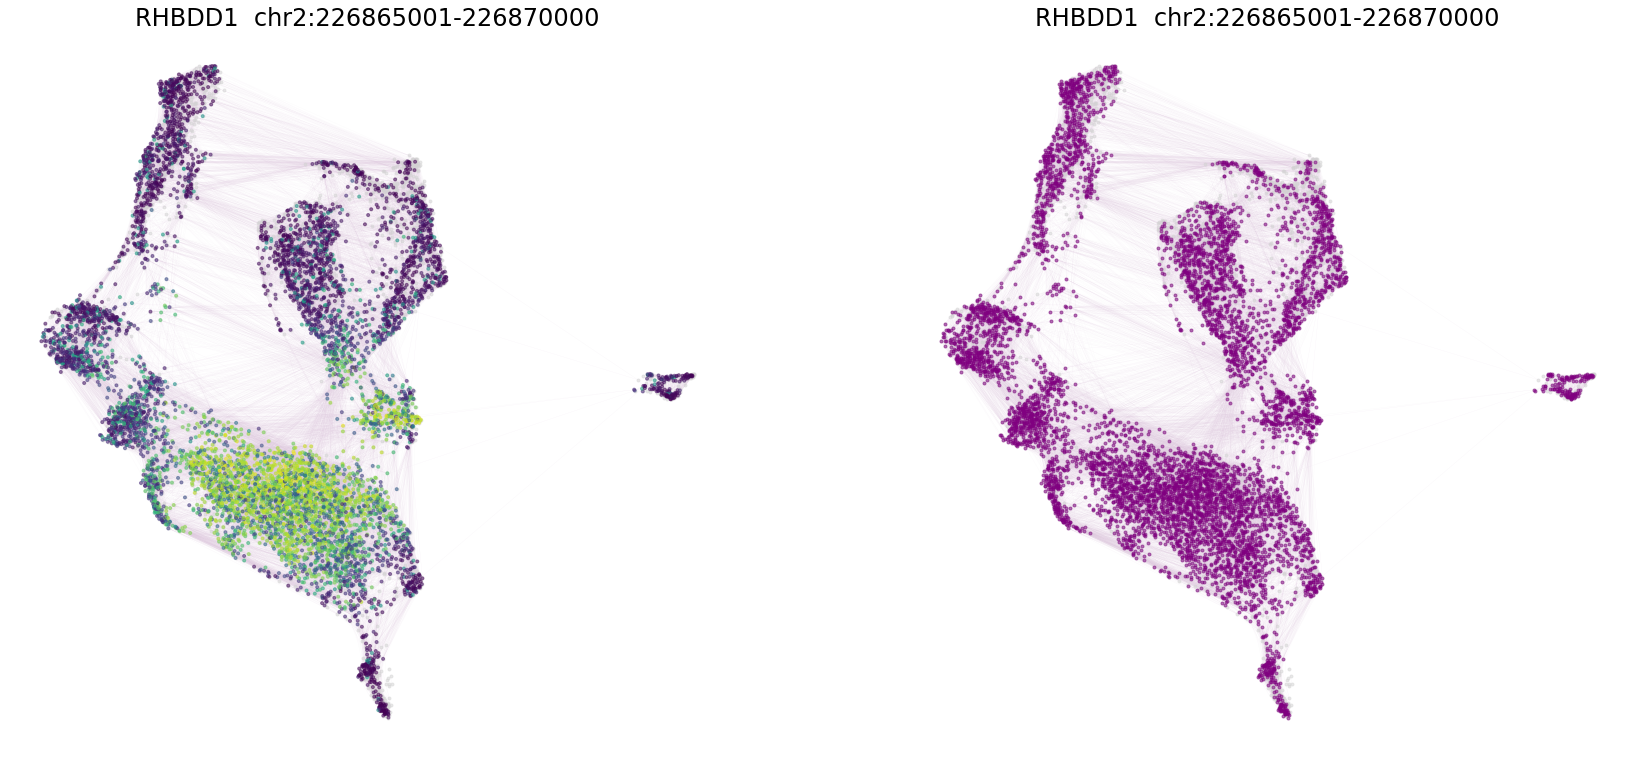

In [51]:
from cytograph.plotting.colors import *
from matplotlib.collections import LineCollection

g = ds.col_graphs.RNN
has_edges = True

# Compute a good size for the markers, based on local density
min_pts = 50
eps_pct = 60

knn = ds.col_graphs['KNN']
k_radius = knn.max(axis=1).toarray()
epsilon = (250 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_axes([0, 0, 0.4, 1])

lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
ax.add_collection(lc)

ax.scatter(pos[:,0], pos[:,1],s=epsilon, c = 'lightgrey', alpha=.5)
ax.scatter(pos[k,0], pos[k,1],s=epsilon, c = v, cmap='viridis', alpha=.5)
ax.set_title(f"{ds.ra['Gene'][b][0]}  {ds.ra['chrom'][b][0]}:{ds.ra['start'][b][0]}-{ds.ra['end'][b][0]}", 
             {'fontsize': 24})

ax.axis("off")

ax2 = fig.add_axes([0.5, 0, 0.4, 1])
lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
ax2.add_collection(lc)

ax2.scatter(pos[:,0], pos[:,1],s=epsilon, c = 'lightgrey', alpha=.5)
ax2.scatter(pos[k,0], pos[k,1],s=epsilon, c = 'purple', alpha=.5)
ax2.set_title(f"{ds.ra['Gene'][b][0]}  {ds.ra['chrom'][b][0]}:{ds.ra['start'][b][0]}-{ds.ra['end'][b][0]}", 
             {'fontsize': 24})

ax2.axis("off")
out_file = os.path.join('/'.join(f.split('/')[:-1]), 'plots', f"{ds.attrs['tissue']}_{ds.ra['Gene'][b][0]}_{emb}.png")
# fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')

2967


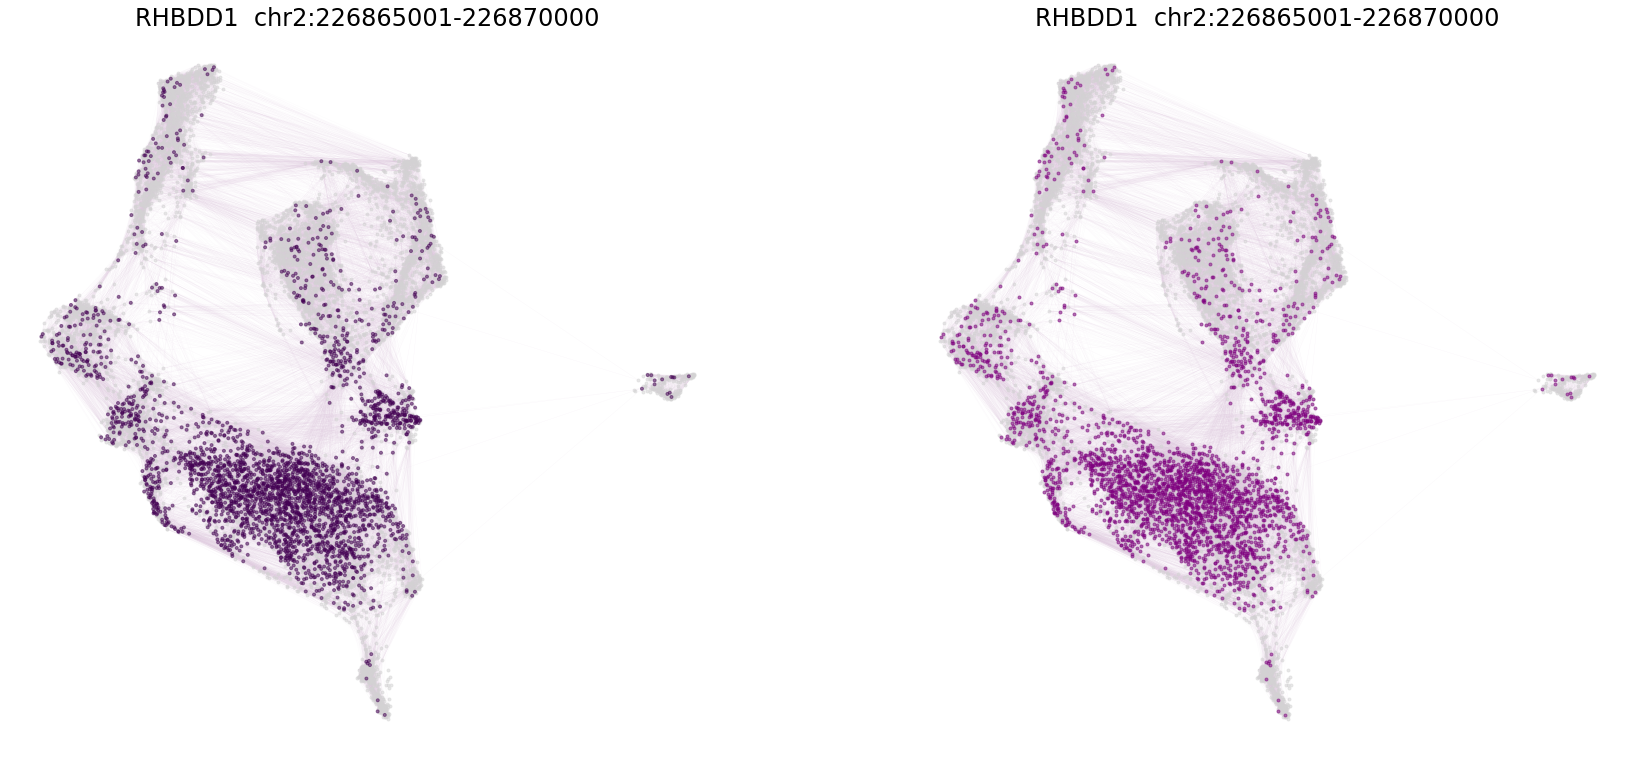

In [11]:
from cytograph.plotting.colors import *
from matplotlib.collections import LineCollection

emb = 'UMAP'
ID = 95163
pos = ds.ca[emb]

b = ds.ra['ID'] == ID
k = (ds[blayer][b,:] > 0).flatten()
print(sum(k))
v = ds['smooth'][b,:].flatten()[k]


g = ds.col_graphs.RNN
has_edges = True

# Compute a good size for the markers, based on local density
min_pts = 50
eps_pct = 60

knn = ds.col_graphs['KNN']
k_radius = knn.max(axis=1).toarray()
epsilon = (250 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_axes([0, 0, 0.4, 1])

lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
ax.add_collection(lc)

ax.scatter(pos[:,0], pos[:,1],s=epsilon, c = 'lightgrey', alpha=.5)
ax.scatter(pos[k,0], pos[k,1],s=epsilon, c = v, cmap='viridis', alpha=.5)
ax.set_title(f"{ds.ra['Gene'][b][0]}  {ds.ra['chrom'][b][0]}:{ds.ra['start'][b][0]}-{ds.ra['end'][b][0]}", 
             {'fontsize': 24})

ax.axis("off")

ax2 = fig.add_axes([0.5, 0, 0.4, 1])
lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
ax2.add_collection(lc)

ax2.scatter(pos[:,0], pos[:,1],s=epsilon, c = 'lightgrey', alpha=.5)
ax2.scatter(pos[k,0], pos[k,1],s=epsilon, c = 'purple', alpha=.5)
ax2.set_title(f"{ds.ra['Gene'][b][0]}  {ds.ra['chrom'][b][0]}:{ds.ra['start'][b][0]}-{ds.ra['end'][b][0]}", 
             {'fontsize': 24})

ax2.axis("off")
out_file = os.path.join('/'.join(f.split('/')[:-1]), 'plots', f"{ds.attrs['tissue']}_{ds.ra['Gene'][b][0]}_{emb}.png")
# fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')

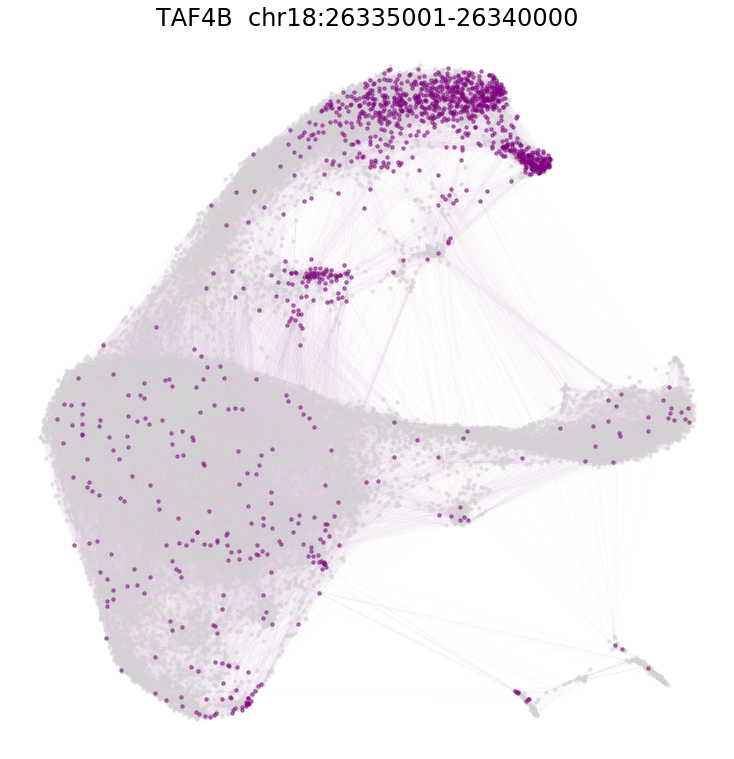

In [77]:
from cytograph.plotting.colors import *
from matplotlib.collections import LineCollection

emb = 'UMAP'
ID = 551272
pos = ds.ca[emb]

b = ds.ra['ID'] == ID
k = (ds[b,:] > 0).flatten()
v = ds[blayer][b,:].flatten()


g = ds.col_graphs.RNN
has_edges = True

# Compute a good size for the markers, based on local density
min_pts = 50
eps_pct = 60

knn = ds.col_graphs['KNN']
k_radius = knn.max(axis=1).toarray()
epsilon = (250 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_axes([0, 0, 0.4, 1])

lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
ax.add_collection(lc)

ax.scatter(pos[:,0], pos[:,1],s=epsilon, c = 'lightgrey', alpha=.5)
ax.scatter(pos[k,0], pos[k,1],s=epsilon, c = 'purple', alpha=.5)
# ax.set_title(f"{ds.ra['Gene'][b][0]}  {ds.ra['chrom'][b][0]}:{ds.ra['start'][b][0]}-{ds.ra['end'][b][0]} dist to gene: {ds.ra['Distance'][b][0]}", 
#              {'fontsize': 24})
ax.set_title(f"{ds.ra['Gene'][b][0]}  {ds.ra['chrom'][b][0]}:{ds.ra['start'][b][0]}-{ds.ra['end'][b][0]}", 
             {'fontsize': 24})

ax.axis("off")
out_file = os.path.join('/'.join(f.split('/')[:-1]), 'plots', f"{ds.attrs['tissue']}_{ds.ra['Gene'][b][0]}_{emb}.png")
fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')

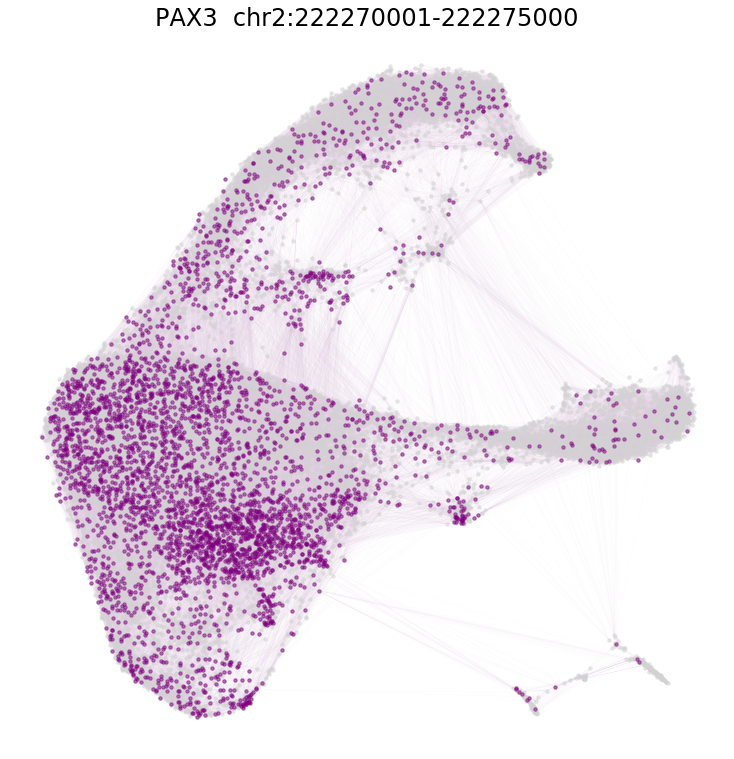

In [73]:
from cytograph.plotting.colors import *
from matplotlib.collections import LineCollection

emb = 'UMAP'
ID = 94244
pos = ds.ca[emb]

b = ds.ra['ID'] == ID
k = (ds[b,:] > 0).flatten()
v = ds[blayer][b,:].flatten()


g = ds.col_graphs.RNN
has_edges = True

# Compute a good size for the markers, based on local density
min_pts = 50
eps_pct = 60

knn = ds.col_graphs['KNN']
k_radius = knn.max(axis=1).toarray()
epsilon = (250 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_axes([0, 0, 0.4, 1])

lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
ax.add_collection(lc)

ax.scatter(pos[:,0], pos[:,1],s=epsilon, c = 'lightgrey', alpha=.5)
ax.scatter(pos[k,0], pos[k,1],s=epsilon, c = 'purple', alpha=.5)
# ax.set_title(f"{ds.ra['Gene'][b][0]}  {ds.ra['chrom'][b][0]}:{ds.ra['start'][b][0]}-{ds.ra['end'][b][0]}", 
#              {'fontsize': 24})
ax.set_title(f"{ds.ra['Gene'][b][0]}  {ds.ra['chrom'][b][0]}:{ds.ra['start'][b][0]}-{ds.ra['end'][b][0]}", 
             {'fontsize': 24})

ax.axis("off")
out_file = os.path.join('/'.join(f.split('/')[:-1]), 'plots', f"{ds.attrs['tissue']}_{ds.ra['Gene'][b][0]}_{emb}.png")
fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')

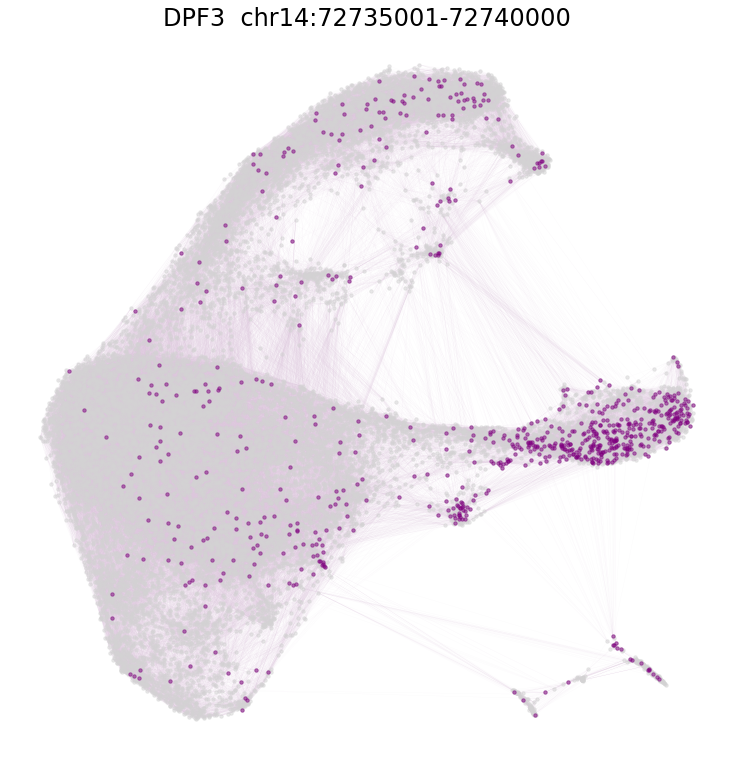

In [74]:
from cytograph.plotting.colors import *
from matplotlib.collections import LineCollection

emb = 'UMAP'
ID = 484034
pos = ds.ca[emb]

b = ds.ra['ID'] == ID
k = (ds[b,:] > 0).flatten()
v = ds[blayer][b,:].flatten()


g = ds.col_graphs.RNN
has_edges = True

# Compute a good size for the markers, based on local density
min_pts = 50
eps_pct = 60

knn = ds.col_graphs['KNN']
k_radius = knn.max(axis=1).toarray()
epsilon = (250 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_axes([0, 0, 0.4, 1])

lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
ax.add_collection(lc)

ax.scatter(pos[:,0], pos[:,1],s=epsilon, c = 'lightgrey', alpha=.5)
ax.scatter(pos[k,0], pos[k,1],s=epsilon, c = 'purple', alpha=.5)
# ax.set_title(f"{ds.ra['Gene'][b][0]}  {ds.ra['chrom'][b][0]}:{ds.ra['start'][b][0]}-{ds.ra['end'][b][0]} dist to gene: {ds.ra['Distance'][b][0]}", 
#              {'fontsize': 24})
ax.set_title(f"{ds.ra['Gene'][b][0]}  {ds.ra['chrom'][b][0]}:{ds.ra['start'][b][0]}-{ds.ra['end'][b][0]}", 
             {'fontsize': 24})

ax.axis("off")
out_file = os.path.join('/'.join(f.split('/')[:-1]), 'plots', f"{ds.attrs['tissue']}_{ds.ra['Gene'][b][0]}_{emb}.png")
fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')

In [19]:
g = ds.col_graphs['MKNN'].toarray()
vals = []
x = 0

%timeit nn = g[:,x]>0
%timeit nn_n = sum(nn)
%timeit v = ds[blayer][:,x] + np.sum(ds[blayer][:,nn], axis=1) / (nn_n+1)
vals.append(v)
    

90.9 µs ± 207 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
18.5 ms ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.7 s ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Interactive namespace is empty.


In [632]:
def smooth_bins(ds: loompy.LoomConnection, graph = 'MKNN') -> None:
    '''
    '''
    g = ds.col_graphs[graph].toarray()
    vals = []
#     for x in range(ds.shape[1]):
    for x in range(5):
        nn = g[:,x]>0
        nn_n = sum(nn)
        v = ds[blayer][:,x] + np.sum(ds[blayer][:,nn], axis=1) / (nn_n+1)
        vals.append(v)

        logging.info(f"Finished {x}")
            
    return np.vstack(vals).T
    

In [16]:
from numba import jit
import numba

# Parallel version
@jit(nopython=True, parallel=True)
def smooth_bins_jit(data, g) -> None:
    '''
    '''
    vals = []
    for x in numba.prange(data.shape[1]):
        nn = g[:,x]>0
        nn_n = np.sum(nn)
        v = data[:,x] + np.sum(data[:,nn], axis=1) / (nn_n+1)
        vals.append(v)
        
    return vals


In [ ]:
g = ds.col_graphs['MKNN'].toarray()
smooth = []
batch = 100
i = 0

# vals = smooth_bins_jit(ds[blayer][:,:], g)

for (ix, selection, view) in ds.scan(axis=0, batch_size=batch):
    g = view.col_graphs['MKNN'].toarray()
    vals = smooth_bins_jit(view[blayer][:,:], g)
    vals = np.array(vals)
    smooth.append(vals)
    i+= batch
    if i% (batch*10) == 0:
        logging.info(f"finished{i} rows")


In [679]:
# nnz = []

# for i in range(0,ds.shape[1], 100):
#     if i + 100 > ds.shape[1]:
#         nnz.append(np.array(ds[blayer][:,i:] > 0))
        
#     else:
#         nnz.append(np.array(ds[blayer][:,i:(i+100)] > 0))
#     if i%1000 == 0:
#         logging.info(i)
# nnz = np.hstack(nnz)
# nnz.dtype = 'int8'

10:40:14 INFO     0
10:40:35 INFO     1000
10:40:54 INFO     2000
10:41:15 INFO     3000
10:41:36 INFO     4000
10:41:55 INFO     5000
10:42:17 INFO     6000
10:42:38 INFO     7000
10:42:57 INFO     8000
10:43:16 INFO     9000


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 100 and the array at index 94 has size 70

In [8]:
genes = BedTool(os.path.join(ref, 'genes', 'genes.gtf'))

coding = []
for x in genes:
    if np.logical_and(x['gene_type'] == 'protein_coding', x[2] == 'gene'):
        coding.append(x)
coding = BedTool(coding)

bins = np.stack([ds.ra['chrom'], ds.ra['start'], ds.ra['end'], ds.ra['ID']]).T.tolist()
bins = BedTool(bins)

annot = bins.sort().closest(coding.sort(), d=True, t='first')
an_dict = {'Accession': [], 'Gene': [], 'Distance': [], 'ID': []}

for x in annot:
    feats = x[12].split(';')[:-1]
    feats = [x.split(' ') for x in feats]
    feats = {k:v for k,v in feats}
    if int(x[13]) > 10000:
        an_dict['Accession'].append('-')
        an_dict['Gene'].append('intergenic')
        an_dict['Distance'].append(0)
        an_dict['ID'].append(int(x[3]))   
    else:
        an_dict['Accession'].append(feats['gene_id'].strip('"'))
        an_dict['Gene'].append(feats['gene_name'].strip('"'))
        an_dict['Distance'].append(int(x[13]))
        an_dict['ID'].append(int(x[3]))
an_dict = {x: np.array(an_dict[x]) for x in an_dict}
an_dict = {x: an_dict[x][an_dict['ID'].argsort()] for x in an_dict}

for x in ['Accession', 'Gene', 'Distance']:
    ds.ra[x] = an_dict[x]

In [53]:
sigGenes = []
Clus = np.unique(ds.ca['Clusters'])
for clus in Clus:
    sigGenes.append(np.vstack((ds.ra['ID'][sigBins[:,clus]], ds.ra['Gene'][sigBins[:,clus]], np.round(ds.ra['Zscore'][sigBins[:,clus],clus]))).T)
[print(k,v) for k,v in enumerate(sigGenes)]

0 [[13033 'AK4' 30.0]
 [14027 'LRRC7' 35.0]
 [16286 'ADGRL2' 34.0]
 [19746 'SNX7' 33.0]
 [21816 'TAF13' 35.0]
 [35667 'RASAL2' 34.0]
 [41433 'intergenic' 41.0]
 [41782 'intergenic' 31.0]
 [44755 'TP53BP2' 32.0]
 [58110 'intergenic' 31.0]
 [64257 'EXOC6B' 32.0]
 [64258 'EXOC6B' 36.0]
 [79313 'intergenic' 32.0]
 [79721 'intergenic' 32.0]
 [80416 'intergenic' 31.0]
 [81239 'GALNT5' 32.0]
 [95163 'RHBDD1' 43.0]
 [111287 'intergenic' 33.0]
 [119762 'BBX' 35.0]
 [132110 'MECOM' 34.0]
 [134160 'USP13' 33.0]
 [146378 'ATP8A1' 31.0]
 [156534 'GRID2' 34.0]
 [161460 'intergenic' 32.0]
 [165727 'intergenic' 31.0]
 [166875 'ANAPC10' 33.0]
 [169358 'GRIA2' 40.0]
 [169762 'intergenic' 31.0]
 [171633 'PALLD' 31.0]
 [176843 'intergenic' 41.0]
 [190851 'ENC1' 31.0]
 [192398 'ATP6AP1L' 33.0]
 [194791 'KIAA0825' 32.0]
 [197592 'FBXL17' 38.0]
 [198556 'MCC' 33.0]
 [199939 'intergenic' 32.0]
 [201423 'intergenic' 31.0]
 [228561 'FAM46A' 31.0]
 [313719 'intergenic' 34.0]
 [328123 'intergenic' 32.0]
 [328124 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [4]:
fs = '/data/proj/scATAC/chromograph/build_20191205/smooth.pkl'
smooth = pickle.load(open(fs, 'rb'))

In [23]:
from scipy.sparse import coo_matrix

# smoothed = np.hstack(smooth)
ds['smoothed'] = 'float32'
i = 0
for view in smooth:
    ds['smoothed'][i:view.shape[1],:] = view.T
    i += view.shape[1]
    logging.info(f"Finished {i} rows ")

16:15:46 INFO     Finished 10000 rows 
16:15:48 INFO     Finished 20000 rows 
16:15:49 INFO     Finished 30000 rows 
16:15:51 INFO     Finished 40000 rows 
16:15:52 INFO     Finished 50000 rows 
16:15:53 INFO     Finished 60000 rows 
16:15:55 INFO     Finished 70000 rows 
16:15:56 INFO     Finished 80000 rows 
16:15:58 INFO     Finished 90000 rows 
16:15:59 INFO     Finished 100000 rows 
16:16:01 INFO     Finished 110000 rows 
16:16:02 INFO     Finished 120000 rows 
16:16:03 INFO     Finished 130000 rows 
16:16:05 INFO     Finished 140000 rows 
16:16:06 INFO     Finished 150000 rows 
16:16:08 INFO     Finished 160000 rows 
16:16:09 INFO     Finished 170000 rows 
16:16:10 INFO     Finished 180000 rows 
16:16:12 INFO     Finished 190000 rows 
16:16:13 INFO     Finished 200000 rows 
16:16:15 INFO     Finished 210000 rows 
16:16:17 INFO     Finished 220000 rows 
16:16:18 INFO     Finished 230000 rows 
16:16:20 INFO     Finished 240000 rows 
16:16:21 INFO     Finished 250000 rows 
16:16:23 

KeyboardInterrupt: 